SURF time: 0.1342s, ORB time: 0.1093s
SURF number of keypoints: 428, ORB number of keypoints: 500


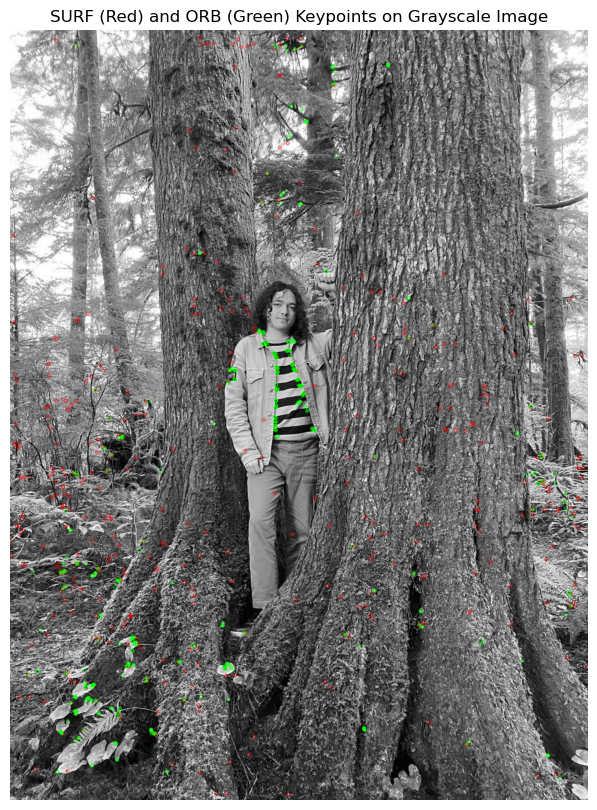

In [2]:
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import time


def compute_integral_image(image):
    return cv2.integral(image, sdepth=cv2.CV_64F)

def compute_box_filter(integral_image, x, y, size):
    half_size = size // 2
    if x - half_size < 0 or y - half_size < 0 or x + half_size >= integral_image.shape[1] or y + half_size >= integral_image.shape[0]:
        return 0
    A = integral_image[y - half_size, x - half_size]
    B = integral_image[y - half_size, x + half_size]
    C = integral_image[y + half_size, x - half_size]
    D = integral_image[y + half_size, x + half_size]
    return D - B - C + A

def detect_keypoints(integral_image, threshold, image):
    harris_response = cv2.cornerHarris(image, blockSize=2, ksize=3, k=0.04)
    keypoints = np.argwhere(harris_response > threshold * harris_response.max())
    keypoints_list = []
    for kp in keypoints:
        y, x = kp
        Dxx = compute_box_filter(integral_image, x, y, size=9)
        Dyy = compute_box_filter(integral_image, x, y, size=9)
        Dxy = compute_box_filter(integral_image, x, y, size=3)
        det = Dxx * Dyy - (0.9 * Dxy) ** 2
        keypoints_list.append((x, y, det))
    return keypoints_list

def non_max_suppression(keypoints, grid_size=10):
    grid = {}
    suppressed_keypoints = []
    for kp in sorted(keypoints, key=lambda x: x[2], reverse=True):
        grid_x, grid_y = int(kp[0] // grid_size), int(kp[1] // grid_size)
        if (grid_x, grid_y) not in grid:
            grid[(grid_x, grid_y)] = kp
            suppressed_keypoints.append(kp)
    return suppressed_keypoints

def build_image_pyramid(image, num_scales=3, scale_factor=1.2):
    pyramid = [image]
    for i in range(1, num_scales):
        scaled_image = cv2.resize(image, (0, 0), fx=1/(scale_factor**i), fy=1/(scale_factor**i), interpolation=cv2.INTER_LINEAR)
        pyramid.append(scaled_image)
    return pyramid

def extract_surf_descriptor(keypoint, image):
    x, y = int(keypoint.pt[0]), int(keypoint.pt[1])
    patch_size = 20
    half_patch = patch_size // 2
    patch = image[max(0, y - half_patch):min(image.shape[0], y + half_patch),
                  max(0, x - half_patch):min(image.shape[1], x + half_patch)]
    if patch.shape[0] < patch_size or patch.shape[1] < patch_size:
        return np.zeros(64, dtype=np.float32)
    sobel_x = cv2.Sobel(patch, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(patch, cv2.CV_64F, 0, 1, ksize=3)
    descriptor = []
    subregion_size = patch_size // 4
    for i in range(4):
        for j in range(4):
            subregion_x = sobel_x[i * subregion_size:(i + 1) * subregion_size, j * subregion_size:(j + 1) * subregion_size]
            subregion_y = sobel_y[i * subregion_size:(i + 1) * subregion_size, j * subregion_size:(j + 1) * subregion_size]
            sum_x = np.sum(subregion_x)
            sum_y = np.sum(subregion_y)
            abs_sum_x = np.sum(np.abs(subregion_x))
            abs_sum_y = np.sum(np.abs(subregion_y))
            descriptor.extend([sum_x, sum_y, abs_sum_x, abs_sum_y])
    return np.array(descriptor, dtype=np.float32)

def extract_descriptors_parallel(keypoints, image):
    with ThreadPoolExecutor() as executor:
        results = executor.map(lambda kp: extract_surf_descriptor(kp, image), keypoints)
        descriptors = list(results)
    return np.array(descriptors, dtype=np.float32)

def calculate_surf_descriptors(image_path, threshold=.3, num_scales=3, grid_size=10):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    pyramid = build_image_pyramid(gray_image, num_scales=num_scales)
    all_keypoints = []
    for scale_idx, scaled_image in enumerate(pyramid):
        integral_image = compute_integral_image(scaled_image)
        keypoints = detect_keypoints(integral_image, threshold, scaled_image)
        all_keypoints.extend([(kp[0], kp[1], kp[2], scale_idx) for kp in keypoints])
    keypoints = non_max_suppression(all_keypoints, grid_size=grid_size)
    points2f = np.array([(k[0], k[1]) for k in keypoints], dtype=np.float32)
    keypoints_cv2 = cv2.KeyPoint_convert(points2f, size=1.0)
    descriptors = extract_descriptors_parallel(keypoints_cv2, gray_image)
    return keypoints_cv2, descriptors, image

# SURF detection and timing
image_path = '/Users/courtneyd/SenoirProject/GSIM-Backend/IMG_0612.jpg'

# Start timing for SURF
start_time_surf = time.time()

keypoints_cv2_surf, descriptors_surf, image_surf = calculate_surf_descriptors(image_path)

end_time_surf = time.time()
surf_time = end_time_surf - start_time_surf

# ORB detection and timing
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Start timing for ORB
start_time_orb = time.time()

# Initiate ORB detector
orb = cv2.ORB_create()
# find the keypoints with ORB
kp_orb = orb.detect(img, None)
# compute the descriptors with ORB
kp_orb, des_orb = orb.compute(img, kp_orb)

end_time_orb = time.time()
orb_time = end_time_orb - start_time_orb

# Results comparison
print(f"SURF time: {surf_time:.4f}s, ORB time: {orb_time:.4f}s")
print(f"SURF number of keypoints: {len(keypoints_cv2_surf)}, ORB number of keypoints: {len(kp_orb)}")

# Clone the grayscale image to draw on the same one
combined_image_gray = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert grayscale to BGR to allow colored keypoints

# Draw SURF keypoints in red (0, 0, 255)
combined_image_with_surf = cv2.drawKeypoints(combined_image_gray, keypoints_cv2_surf, None, color=(0, 0, 255), flags=0)

# Draw ORB keypoints in green (0, 255, 0)
combined_image_with_orb_and_surf = cv2.drawKeypoints(combined_image_with_surf, kp_orb, None, color=(0, 255, 0), flags=0)
'''
Something is going wrong with the plots on the surf descriptors (in red) 
They're getting translated to the top left.
See image of butterfly for example
'''
# Display the combined image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(combined_image_with_orb_and_surf, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for correct display
plt.title(f"SURF (Red) and ORB (Green) Keypoints on Grayscale Image")
plt.axis('off')
plt.show()

